## Loading the python packages

In [215]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
# Load libraries
import os
import alpaca_trade_api as tradeapi
import numpy as np
import pandas as pd
from datetime import datetime

from techanalysislib import SMA, EMA, ROC, MOM, RSI, STOK, STOD

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [217]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

Next, we extract the data required for our analysis using pandas datareader. 

In [218]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [219]:
# Set the Tesla tickers
ticker = ["FTNT"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2013-01-01", 
                          tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-08-17", 
                        tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for Tesla and Coca-Cola
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.count()

FTNT  open      1000
      high      1000
      low       1000
      close     1000
      volume    1000
dtype: int64

In [220]:
# shape of the data
df_ticker.tail()

FTNT                                  
                             open    high       low   close  volume
2021-08-11 00:00:00-04:00  301.16  302.98  293.7076  298.64  871783
2021-08-12 00:00:00-04:00  299.34  309.79  298.2800  305.59  897462
2021-08-13 00:00:00-04:00  303.94  309.53  302.2100  309.37  534405
2021-08-16 00:00:00-04:00  309.00  309.00  298.6700  302.60  689011
2021-08-17 00:00:00-04:00  301.67  302.27  295.1895  298.64  773167

## Data Preparation

In [221]:
stock_data = df_ticker.loc[:,'FTNT']
stock_data.shape

(1000, 5)

In [222]:
#Checking for null values and removing the null values if any
print('Null Values =',stock_data.isnull().values.any())

Null Values = False


In [223]:
# Calculate daily return
stock_data['daily_return'] = stock_data['close'].pct_change()
stock_data['upside'] = np.where(stock_data['daily_return'] > 0, 1.0, 0.0)

stock_data.head()

,open,high,low,close,volume,daily_return,upside
2017-08-24 00:00:00-04:00,37.17,37.5200,37.1100,37.230,576162,NaN,0.0
2017-08-25 00:00:00-04:00,37.48,37.6497,37.0800,37.180,671202,-0.001343,0.0
2017-08-28 00:00:00-04:00,37.21,37.3200,37.0400,37.260,321998,0.002152,1.0
2017-08-29 00:00:00-04:00,37.00,37.4900,36.9500,37.365,399069,0.002818,1.0
2017-08-30 00:00:00-04:00,37.39,37.9000,37.2901,37.850,450683,0.012980,1.0


## Feature Engineering

Our approach is based on price momentum. We will derive momentum fatures that will be used to predict future signals.

The current Data consists of date, open, high, low, close and volume. Following momentum indicatord are calculated using this data. 
* **Exponential Moving Average** : provides an indication of the overall trend of the price movement by smooting high volatility of the price movement.  
* **Stochastic Oscillator %K and %D** : a momentum indicator that compares a closing price to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** : a momentum indicator that measures the magnitude of recent price changes and indicates if the stock is overbought or oversold. 
* **Rate Of Change(ROC)**: a momentum oscillator that measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : measure the speed at which the price is changing.

In [224]:
stock_data['EMA10'] = EMA(stock_data, 10)
stock_data['EMA30'] = EMA(stock_data, 30)
stock_data['EMA200'] = EMA(stock_data, 200)

In [225]:
stock_data['ROC10'] = ROC(stock_data['close'], 10)
stock_data['ROC30'] = ROC(stock_data['close'], 30)

In [226]:
stock_data['MOM10'] = MOM(stock_data['close'], 10)
stock_data['MOM30'] = MOM(stock_data['close'], 30)

In [227]:
stock_data['RSI10'] = RSI(stock_data['close'], 10)
stock_data['RSI30'] = RSI(stock_data['close'], 30)
stock_data['RSI200'] = RSI(stock_data['close'], 200)

In [228]:
stock_data['%D10'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 10)
stock_data['%K30'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%D30'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%K200'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 200)
stock_data['%D200'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 200)

In [229]:
stock_data['MA10'] = SMA(stock_data, 10)
stock_data['MA30'] = SMA(stock_data, 30)
stock_data['MA200'] = SMA(stock_data, 200)

In [230]:
stock_data.tail(2)

,open,high,low,close,volume,daily_return,upside,EMA10,EMA30,EMA200,...,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-08-16 00:00:00-04:00,309.00,309.00,298.6700,302.60,689011,-0.021883,0.0,299.007703,279.443757,204.183077,...,71.050975,62.613350,87.802342,88.796086,94.147716,96.458826,98.061137,302.321,276.632667,188.954046
2021-08-17 00:00:00-04:00,301.67,302.27,295.1895,298.64,773167,-0.013087,0.0,298.940848,280.682224,205.122989,...,68.445522,62.151405,67.398053,82.625362,90.262750,94.508471,96.920147,302.411,278.216000,189.857146


In [231]:
#excluding columns that are not needed for our prediction.
stock_data_bkup = stock_data.copy()
stock_data = stock_data.drop(['high','low','open','volume','daily_return'], axis=1)

In [232]:
stock_data = stock_data.dropna(axis=0)

In [233]:
stock_data.tail(2)

,close,upside,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-08-16 00:00:00-04:00,302.60,0.0,299.007703,279.443757,204.183077,1.632297,20.490563,17.98,54.55,66.759950,71.050975,62.613350,87.802342,88.796086,94.147716,96.458826,98.061137,302.321,276.632667,188.954046
2021-08-17 00:00:00-04:00,298.64,0.0,298.940848,280.682224,205.122989,-1.769620,17.885762,0.90,47.50,60.574782,68.445522,62.151405,67.398053,82.625362,90.262750,94.508471,96.920147,302.411,278.216000,189.857146


## Data Visualization

In [234]:
stock_data.columns

Index(['close', 'upside', 'EMA10', 'EMA30', 'EMA200', 'ROC10', 'ROC30',
       'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%D10', '%K30', '%D30',
       '%K200', '%D200', 'MA10', 'MA30', 'MA200'],
      dtype='object')

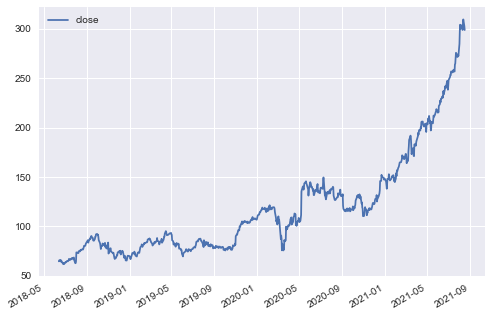

In [235]:
stock_data[['close']].plot(grid=True)
plt.show()

In [236]:
stock_data=stock_data.drop(['close'], axis=1)

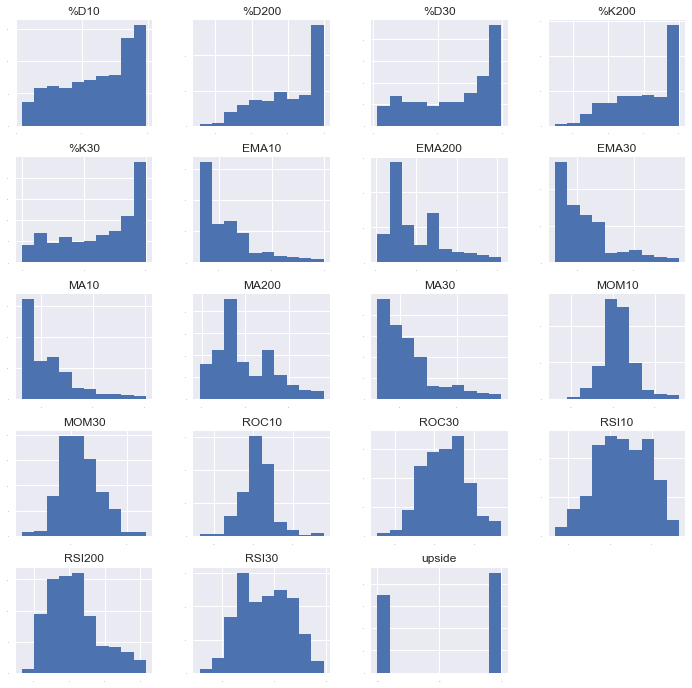

In [237]:
# histograms to understand how data is distributed
stock_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

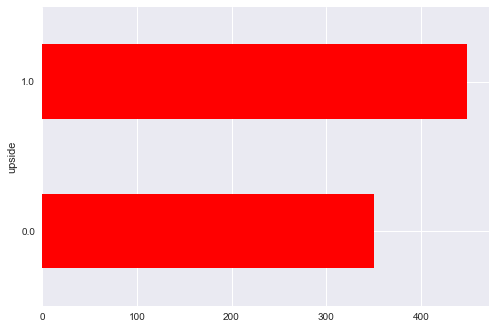

In [238]:
fig = plt.figure()
plot = stock_data.groupby(['upside']).size().plot(kind='barh', color='red')
plt.show()

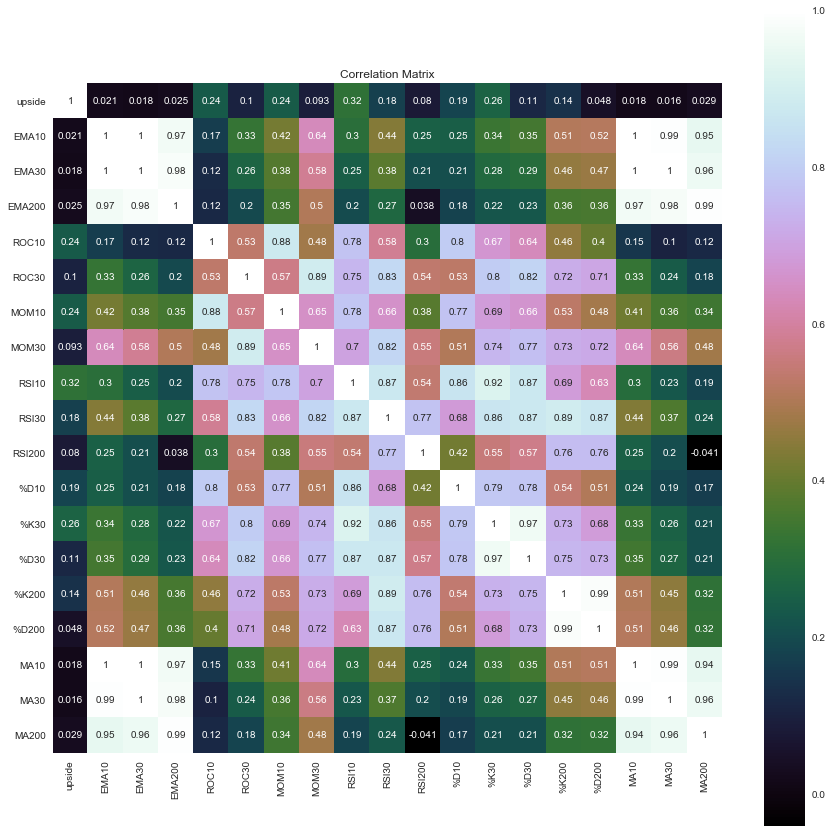

In [239]:
# correlation
correlation = stock_data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Model training and evaluation

In [240]:
# Construct training start and end dates
training_start = stock_data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-09-30'

# Construct testing start and end dates
testing_start =  '2020-08-01'
testing_end = stock_data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-06-13
Training End: 2020-09-30
Testing Start: 2020-08-01
Testing End: 2021-08-17


In [241]:
# split out train and test dataset 
y_train = stock_data["upside"][training_start:training_end]
X_train = stock_data.loc[:, stock_data.columns != 'upside'][training_start:training_end]

y_test = stock_data["upside"][testing_start:testing_end]
X_test = stock_data.loc[:, stock_data.columns != 'upside'][testing_start:testing_end]

In [242]:
X_train.head()

,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2018-06-13 00:00:00-04:00,62.811581,60.425659,51.678183,5.702614,15.621090,3.50,8.94,73.222483,66.821898,62.375687,92.041839,95.921835,97.030793,98.385469,98.873185,62.8229,60.032067,47.332562
2018-06-14 00:00:00-04:00,63.340385,60.767230,51.839026,6.051315,17.168836,4.52,9.77,76.827886,68.416557,62.725196,92.620875,95.763700,97.104481,98.231955,98.826033,63.2749,60.357733,47.474862
2018-06-15 00:00:00-04:00,63.691224,61.057731,51.992642,4.482151,19.192841,3.30,9.18,72.114440,66.961959,62.470386,86.868409,92.265838,94.650458,96.772101,97.796508,63.6049,60.663733,47.614387
2018-06-18 00:00:00-04:00,64.140092,61.386910,52.154439,4.683544,18.779174,3.69,11.40,75.427330,68.339183,62.771001,89.583581,98.615917,95.548485,99.481865,98.161973,63.9739,61.043733,47.755937
2018-06-19 00:00:00-04:00,64.172803,61.576142,52.293171,1.611374,12.980854,1.12,8.62,59.256014,62.745192,61.743383,80.782823,81.867634,90.916463,93.523316,96.592427,64.0859,61.331067,47.886437


In [243]:
# Standard scaling
scaler = StandardScaler().fit(X_train)
rescaledX_train = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

## Models

In [244]:
models = []
models.append(('  LR', LogisticRegression(n_jobs=-1)))
models.append((' KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Ensable Models 
#Boosting methods
models.append(('  AB', AdaBoostClassifier()))
models.append((' XGB', XGBClassifier(verbosity = 0)))

#Bagging methods
models.append(('  RF', RandomForestClassifier(n_jobs=-1)))

### Neural network based models were not considered as the sample size is small - NN will overfit on the data

In [245]:
models

[('  LR', LogisticRegression(n_jobs=-1)),
 (' KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('  AB', AdaBoostClassifier()),
 (' XGB',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=0)),
 ('  RF', RandomForestClassifier(n_jobs=-1))]

In [246]:
rescaledX_train.shape

(578, 18)

In [247]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png", width=600, height=200)

In [248]:
# evaluation metrics for classification
num_folds = 5
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring = 'roc_auc'

In [249]:
results = []
names = []
print("Model   Avg. Accuracy     Std Deviation")
print("---------------------------------------")

for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    cv_results = cross_val_score(model, rescaledX_train, y_train, cv=kfold, scoring=scoring)
    
    results.append(cv_results)
    names.append(name)
    
    msg = f'{name}     {round(cv_results.mean()*100,2)}%           {round(cv_results.std(),3)}'
    print(msg)   

Model   Avg. Accuracy     Std Deviation
---------------------------------------
  LR     79.94%           0.027
 KNN     59.34%           0.024
CART     71.97%           0.025
  AB     74.23%           0.028
 XGB     74.22%           0.032
  RF     67.48%           0.016


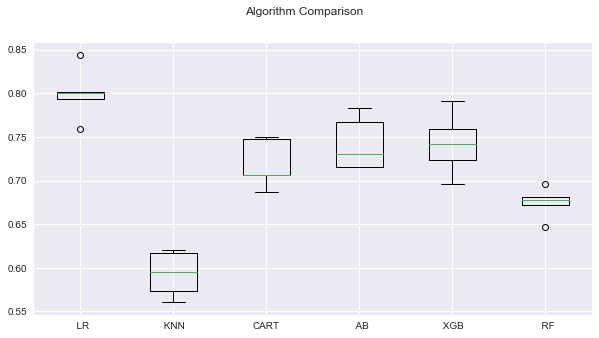

In [250]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(10,5)
plt.show()

#### This gives me the confidence that I have INFORMATIVE FEATURES and one of these models will be a good fit to the data. However, none of these models are tuned

Two types of parameters:  
(1)    Model Parameters - learnt from data  
(2)    Hyper parameters - Manual tuning needed (not learnt from data)

# RANDOM FOREST #

## Hyper Parameter Tuning for RandomForest with Grid Search

In [251]:
criterion = ["gini","entropy"]
n_estimators = [20,40,80]
max_depth = range(1,10)

model = RandomForestClassifier()
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.719640 using {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 80}
#51 0.622789 (0.036921) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 20}
#46 0.627946 (0.034174) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 40}
#52 0.622774 (0.034183) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 80}
#53 0.617631 (0.026052) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20}
#47 0.627931 (0.037289) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 40}
#43 0.633163 (0.038930) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 80}
#40 0.640105 (0.028569) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 20}
#35 0.652219 (0.038598) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 40}
#37 0.650465 (0.036918) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 80}
#30 0.662699 (0.040687) with: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 20}
#38 0.648741 (0.030288) with: {'criter

## Fit the model and Run the trained model on the test dataset

In [284]:
# Setup the model based on the parameters suggested by Grid Search
model_rf = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=80) 
model_rf.fit(rescaledX_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=80)

In [285]:
# Accuracy metrics on the test set
predictions = model_rf.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7777777777777778
[[ 60  47]
 [ 11 143]]
              precision    recall  f1-score   support

         0.0       0.85      0.56      0.67       107
         1.0       0.75      0.93      0.83       154

    accuracy                           0.78       261
   macro avg       0.80      0.74      0.75       261
weighted avg       0.79      0.78      0.77       261



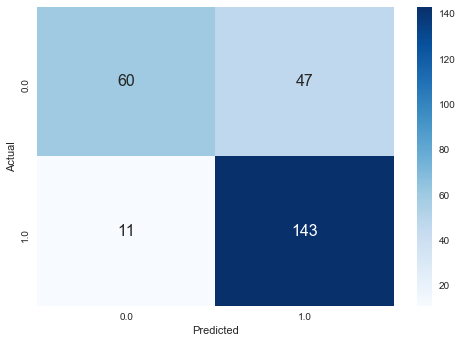

In [286]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d') # font size

Text(0.5, 0, 'Variable Importance')

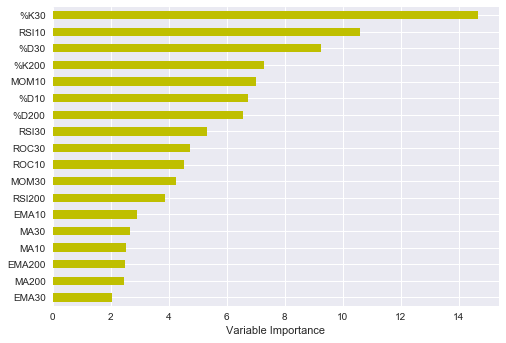

In [287]:
Importance = pd.DataFrame({'Importance':model_rf.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

# LOGISTIC REGRESSION 

## Hyper Parameter Tuning for Logistic Regression with Grid Search

In [256]:
#Grid Search for Logistic Regression to maximize recall
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.811349 using {'C': 5, 'penalty': 'l2'}
#9 nan (nan) with: {'C': 0.001, 'penalty': 'l1'}
#8 0.600330 (0.025547) with: {'C': 0.001, 'penalty': 'l2'}
#10 nan (nan) with: {'C': 0.009, 'penalty': 'l1'}
#6 0.650495 (0.015521) with: {'C': 0.009, 'penalty': 'l2'}
#11 nan (nan) with: {'C': 0.01, 'penalty': 'l1'}
#7 0.641844 (0.015535) with: {'C': 0.01, 'penalty': 'l2'}
#12 nan (nan) with: {'C': 0.09, 'penalty': 'l1'}
#5 0.762879 (0.031944) with: {'C': 0.09, 'penalty': 'l2'}
#13 nan (nan) with: {'C': 1, 'penalty': 'l1'}
#4 0.804408 (0.033667) with: {'C': 1, 'penalty': 'l2'}
#14 nan (nan) with: {'C': 5, 'penalty': 'l1'}
#1 0.811349 (0.026911) with: {'C': 5, 'penalty': 'l2'}
#15 nan (nan) with: {'C': 10, 'penalty': 'l1'}
#2 0.809580 (0.029151) with: {'C': 10, 'penalty': 'l2'}
#16 nan (nan) with: {'C': 25, 'penalty': 'l1'}
#3 0.807856 (0.031760) with: {'C': 25, 'penalty': 'l2'}


## Fit the model and Run the trained model on the test dataset

In [257]:
# Setup the model based on the parameters suggested by Grid Search
model_lr = LogisticRegression(penalty = 'l2',C = 5)
model_lr.fit(rescaledX_train, y_train)

LogisticRegression(C=5)

In [258]:
# Accuracy metrics on the test set
predictions = model_lr.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7241379310344828
[[ 40  67]
 [  5 149]]
              precision    recall  f1-score   support

         0.0       0.89      0.37      0.53       107
         1.0       0.69      0.97      0.81       154

    accuracy                           0.72       261
   macro avg       0.79      0.67      0.67       261
weighted avg       0.77      0.72      0.69       261



Text(0.5, 0, 'Variable Importance')

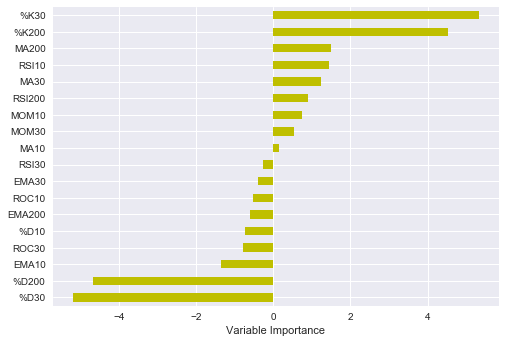

In [259]:
coeff = model_lr.coef_
cols = X_train.columns.values

Importance = pd.DataFrame(coeff.reshape(18,-1), index = cols)
Importance['Importance'] = Importance.iloc[:,0]
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y',legend=None )
plt.xlabel('Variable Importance')

# ADA BOOST

## Hyper Parameter Tuning for Adaboost with Grid Search

In [260]:
n_estimators = [40,80,200]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)
kfold = KFold(n_splits=num_folds)

# Instantiate GridSearchCV, fit model and make prediction
model = AdaBoostClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.707556 using {'learning_rate': 0.2, 'n_estimators': 80}
#13 0.572654 (0.043459) with: {'learning_rate': 0.001, 'n_estimators': 40}
#13 0.572654 (0.043459) with: {'learning_rate': 0.001, 'n_estimators': 80}
#13 0.572654 (0.043459) with: {'learning_rate': 0.001, 'n_estimators': 200}
#10 0.607241 (0.023973) with: {'learning_rate': 0.01, 'n_estimators': 40}
#10 0.607241 (0.023973) with: {'learning_rate': 0.01, 'n_estimators': 80}
#12 0.607226 (0.025458) with: {'learning_rate': 0.01, 'n_estimators': 200}
#8 0.665982 (0.046456) with: {'learning_rate': 0.1, 'n_estimators': 40}
#4 0.690225 (0.031453) with: {'learning_rate': 0.1, 'n_estimators': 80}
#7 0.672774 (0.090562) with: {'learning_rate': 0.1, 'n_estimators': 200}
#5 0.686792 (0.029195) with: {'learning_rate': 0.2, 'n_estimators': 40}
#1 0.707556 (0.035592) with: {'learning_rate': 0.2, 'n_estimators': 80}
#3 0.698816 (0.050396) with: {'learning_rate': 0.2, 'n_estimators': 200}
#2 0.698861 (0.042461) with: {'learning_rate': 0.5, '

## Fit the model and Run the trained model on the test dataset

In [261]:
# Setup the model based on the parameters suggested by Grid Search
model_ab = AdaBoostClassifier(n_estimators=80, learning_rate=0.2)
model_ab.fit(rescaledX_train, y_train)

AdaBoostClassifier(learning_rate=0.2, n_estimators=80)

In [262]:
# Accuracy metrics on the test set
predictions = model_ab.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7701149425287356
[[ 77  30]
 [ 30 124]]
              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       107
         1.0       0.81      0.81      0.81       154

    accuracy                           0.77       261
   macro avg       0.76      0.76      0.76       261
weighted avg       0.77      0.77      0.77       261



Text(0.5, 0, 'Variable Importance')

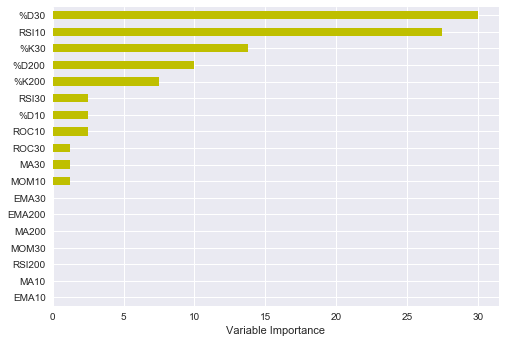

In [263]:
Importance = pd.DataFrame({'Importance':model_ab.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

# KNN classifier hyper parameter tuning

In [264]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

kfold = KFold(n_splits=num_folds)

# Instantiate GridSearchCV, fit model and make prediction
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.660765 using {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
#638 0.631484 (0.033147) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
#2696 0.601979 (0.055413) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
#2745 0.600375 (0.031590) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
#2794 0.586342 (0.055958) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
#50 0.648696 (0.058492) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
#1 0.660765 (0.051132) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
#344 0.636627 (0.056286) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
#2647 0.610600 (0.052966) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
#589 0.633178 (0.047232) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
#99 0.641814 (0.054793) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
#491 0.633208 (0.057447) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
#1324 0.622834 (0.041289) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
#148 0.640165 (0.052262) with: {'leaf_size': 1,

## Fit the model and Run the trained model on the test dataset

In [265]:
# Setup the model based on the parameters suggested by Grid Search
model_knn = KNeighborsClassifier(leaf_size=1, n_neighbors=3, p=2)
model_knn.fit(rescaledX_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=3)

In [266]:
# Accuracy metrics on the test set
predictions = model_knn.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6973180076628352
[[ 39  68]
 [ 11 143]]
              precision    recall  f1-score   support

         0.0       0.78      0.36      0.50       107
         1.0       0.68      0.93      0.78       154

    accuracy                           0.70       261
   macro avg       0.73      0.65      0.64       261
weighted avg       0.72      0.70      0.67       261



# DECISION TREE

## Decision Tree Hyper Parameter Tuning

In [267]:
criterion = ["gini","entropy"]
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)

param_grid = dict(criterion = criterion, max_depth=max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.724933 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 8}
#648 nan (nan) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 1}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7}
#513 0.572654 (0.043459) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 

In [288]:
# Setup the model based on the parameters suggested by Grid Search
model_cart = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 3, min_samples_split = 8)
model_cart.fit(rescaledX_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=8)

In [289]:
# Accuracy metrics on the test set
predictions = model_cart.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7394636015325671
[[ 90  17]
 [ 51 103]]
              precision    recall  f1-score   support

         0.0       0.64      0.84      0.73       107
         1.0       0.86      0.67      0.75       154

    accuracy                           0.74       261
   macro avg       0.75      0.75      0.74       261
weighted avg       0.77      0.74      0.74       261



Text(0.5, 0, 'Variable Importance')

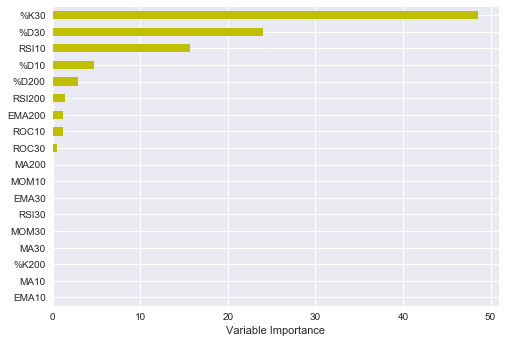

In [290]:
Importance = pd.DataFrame({'Importance':model_cart.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

In [291]:
import graphviz
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

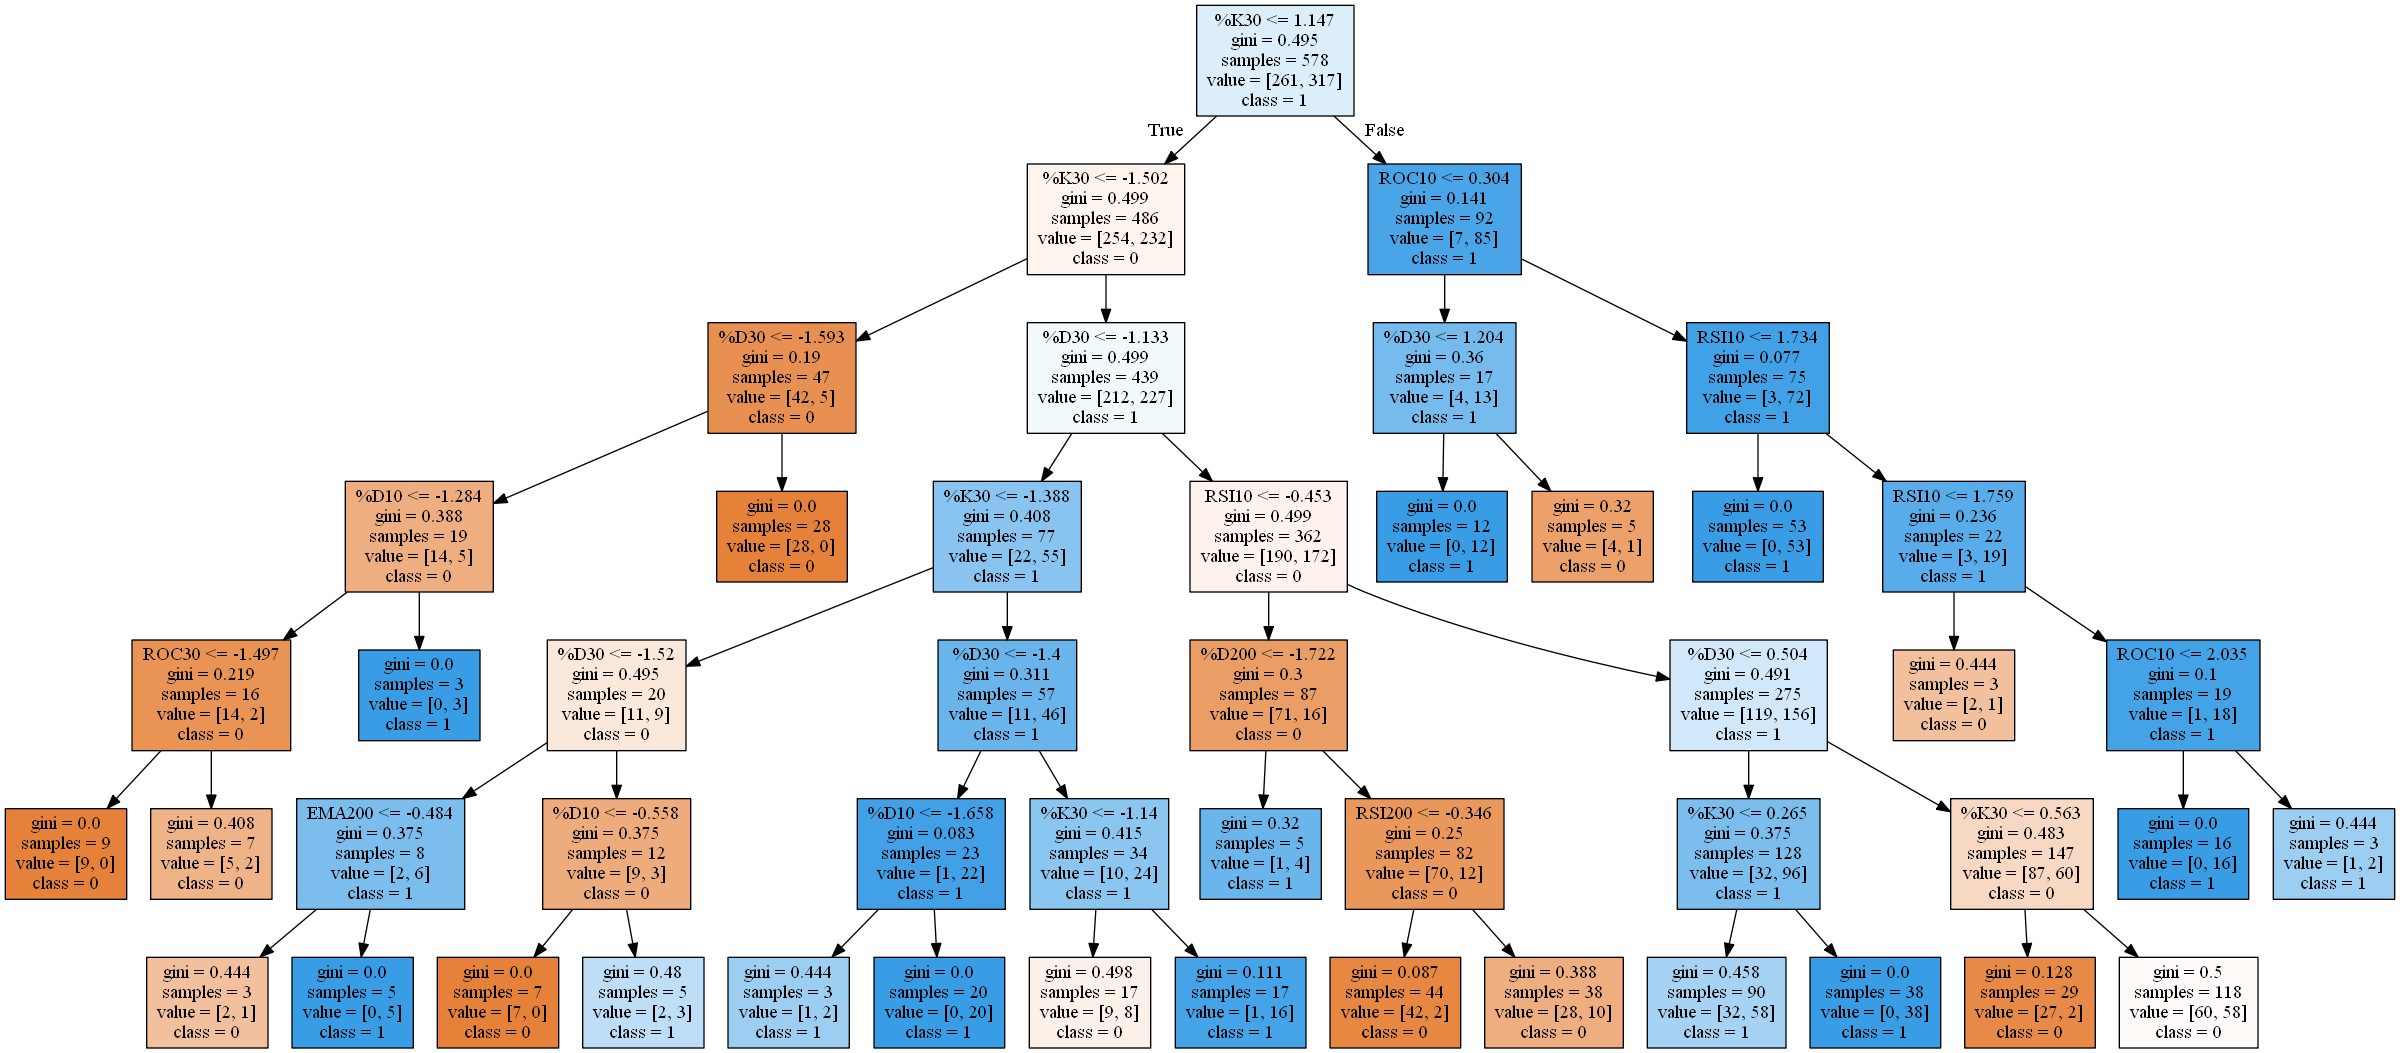

In [292]:
# Create DOT data
dot_data = tree.export_graphviz(
    model_cart, out_file=None, feature_names=X_train.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

# XGBoost hyperparameter optimization

In [273]:
'''
max_depth = [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [100, 500, 1000]

param_grid = dict(max_depth = max_depth, learning_rate = learning_rate, subsample = subsample, colsample_bytree = colsample_bytree, 
                 colsample_bylevel = colsample_bylevel, n_estimators = n_estimators)
model = XGBClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))
    '''

'\nmax_depth = [3, 5, 6, 10, 15, 20]\nlearning_rate = [0.01, 0.1, 0.2, 0.3]\nsubsample = np.arange(0.5, 1.0, 0.1)\ncolsample_bytree = np.arange(0.4, 1.0, 0.1)\ncolsample_bylevel = np.arange(0.4, 1.0, 0.1)\nn_estimators = [100, 500, 1000]\n\nparam_grid = dict(max_depth = max_depth, learning_rate = learning_rate, subsample = subsample, colsample_bytree = colsample_bytree, \n                 colsample_bylevel = colsample_bylevel, n_estimators = n_estimators)\nmodel = XGBClassifier()\nkfold = KFold(n_splits=num_folds)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)\ngrid_result = grid.fit(rescaledX, y_train)\n\n#Print Results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nranks = grid_result.cv_results_[\'rank_test_score\']\nfor mean, stdev, param, rank in zip(means

In [274]:
# Train XGB classifier with default hyper parameters
model_xgb = XGBClassifier()
model_xgb.fit(rescaledX_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [275]:
# Accuracy metrics on the test set
predictions = model_xgb.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8160919540229885
[[ 78  29]
 [ 19 135]]
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       107
         1.0       0.82      0.88      0.85       154

    accuracy                           0.82       261
   macro avg       0.81      0.80      0.81       261
weighted avg       0.82      0.82      0.81       261



# Compare all tuned classifiers and select the best one for prediction
### AUC-ROC curve for all classification models

In [293]:
# predict probabilities
pred_prob_rf = model_rf.predict_proba(rescaledX_test)
pred_prob_lr = model_lr.predict_proba(rescaledX_test)
pred_prob_ab = model_ab.predict_proba(rescaledX_test)
pred_prob_knn = model_knn.predict_proba(rescaledX_test)
pred_prob_cart = model_cart.predict_proba(rescaledX_test)
pred_prob_xgb = model_xgb.predict_proba(rescaledX_test)

In [294]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test, pred_prob_lr[:,1], pos_label=1)
fpr_ab, tpr_ab, thresh_ab = roc_curve(y_test, pred_prob_ab[:,1], pos_label=1)
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_cart, tpr_cart, thresh_cart = roc_curve(y_test, pred_prob_cart[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)

In [295]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

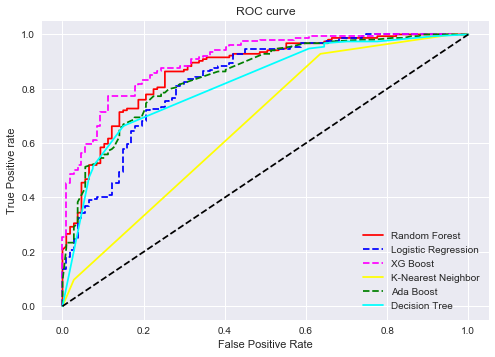

In [296]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_rf, tpr_rf, linestyle='-',color='red', label='Random Forest')
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='blue', label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='magenta', label='XG Boost')
plt.plot(fpr_knn, tpr_knn, linestyle='-',color='yellow', label='K-Nearest Neighbor')
plt.plot(fpr_ab, tpr_ab, linestyle='--',color='green', label='Ada Boost')
plt.plot(fpr_cart, tpr_cart, linestyle='-',color='cyan', label='Decision Tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [297]:
from sklearn.metrics import roc_auc_score

# auc scores
print(f"AUC score for Random Forest      : {roc_auc_score(y_test, pred_prob_rf[:,1])}")
print(f"AUC score for Logistic Regression: {roc_auc_score(y_test, pred_prob_lr[:,1])}")
print(f"AUC score for XG Boost           : {roc_auc_score(y_test, pred_prob_xgb[:,1])}")
print(f"AUC score for K-Nearest Neighbor : {roc_auc_score(y_test, pred_prob_knn[:,1])}")
print(f"AUC score for AdaBoost           : {roc_auc_score(y_test, pred_prob_ab[:,1])}")
print(f"AUC score for Decision Trees     : {roc_auc_score(y_test, pred_prob_cart[:,1])}")

AUC score for Random Forest      : 0.8669134603714044
AUC score for Logistic Regression: 0.8302585265202089
AUC score for XG Boost           : 0.9036290811991747
AUC score for K-Nearest Neighbor : 0.6657968200024276
AUC score for AdaBoost           : 0.8459461099648015
AUC score for Decision Trees     : 0.8174839179512078


# Final Model

In [298]:
# Accuracy metrics on the test set
predictions = model_xgb.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8160919540229885
[[ 78  29]
 [ 19 135]]
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       107
         1.0       0.82      0.88      0.85       154

    accuracy                           0.82       261
   macro avg       0.81      0.80      0.81       261
weighted avg       0.82      0.82      0.81       261



In [299]:
predictions

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 1.

# BACKTESTING

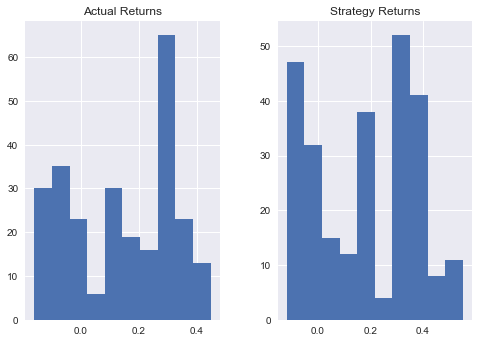

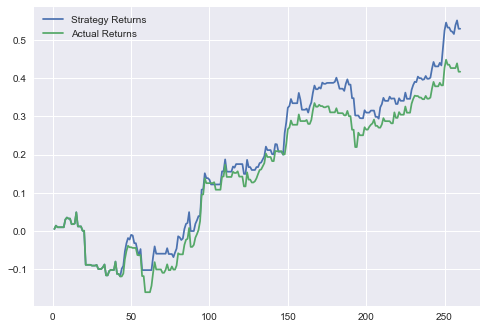

In [300]:
#Create column for Strategy Returns by multiplying the daily returns by the position held at close of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = y_test
test_close_data = stock_data_bkup[testing_start:testing_end]
backtestdata['Market Returns'] = test_close_data['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()